In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import glob
import PIL.Image as Image
import torch.utils.data as data
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm


In [2]:
def calibrate1(x):
    mask = (x >= 0.1) & (x <= 0.9)  # Create a boolean mask for values within the specified range
    scaled_x = np.copy(x)  # Create a copy of the input array
    scaled_x[mask] = (0.01581065 / 0.01783962) * x[mask] + (0.378124 - 0.35546485)  # Apply calibration within the range
    return scaled_x

def calibrate2(x):
    mask = (x >= 0.1) & (x <= 0.9)  # Create a boolean mask for values within the specified range
    scaled_x = np.copy(x)  # Create a copy of the input array
    scaled_x[mask] = (0.01581065/0.01669826) * x[mask] -0.012  # Apply calibration within the range
    return scaled_x

In [3]:
import numba
import numpy as np
from PIL import Image
import torch
from matplotlib import pyplot as plt
from torch.utils.data import Dataset
from typing import Tuple, List
from torchvision.transforms import transforms
import cv2

class VesuviusTrainData(Dataset):
    _relative_sv_dir = "surface_volume"  # relative to the directory of train data

    def __init__(self,
                 dir_path: str = "train/1",
                 z_start: int = 0,
                 z_end: int = 64,
                 nucleus_shape: Tuple[int, int] = (16, 16),
                 hull_size: Tuple[int, int] = (64, 64),
                 compress_depth =  None,
                 give_indx = False,
                 calibrator = None,
                 boundarysize = None
                 ):
        self.dir_path = dir_path

        self.z_start = z_start
        self.z_end = z_end

        self.nucleus_shape = nucleus_shape
        self.hull_size = hull_size
        
        self.compress_depth = compress_depth
        self.give_indx = give_indx
        self.calibrator = calibrator
        self.boundarysize = boundarysize
        
        
        self._setup()

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, index: int):
        i, j = self._get_pixel_from_index(self.indices[index])
        nucleus_height, nucleus_width = self.nucleus_shape
        calibrator = globals().get(self.calibrator)

        if self.give_indx == False:
            if calibrator:
                return (torch.from_numpy(
                    calibrator(self.images[
                    :,
                    i - self._left_hull + self._left_pad_image:
                    i + nucleus_width + self._right_hull + self._left_pad_image,
                    j - self._top_hull + self._top_pad_image:
                    j + nucleus_height + self._bottom_hull + self._top_pad_image
                     ])),
                    torch.from_numpy(
                    self.inklabels[i: i + nucleus_width,
                    j: j + nucleus_height]))
            else:
                return (torch.from_numpy(
                    self.images[
                    :,
                    i - self._left_hull + self._left_pad_image:
                    i + nucleus_width + self._right_hull + self._left_pad_image,
                    j - self._top_hull + self._top_pad_image:
                    j + nucleus_height + self._bottom_hull + self._top_pad_image
                     ]),
                    torch.from_numpy(
                    self.inklabels[i: i + nucleus_width,
                    j: j + nucleus_height])) 
        else:
            if calibrator:
                return (torch.from_numpy(
                    calibrator(self.images[
                    :,
                    i - self._left_hull + self._left_pad_image:
                    i + nucleus_width + self._right_hull + self._left_pad_image,
                    j - self._top_hull + self._top_pad_image:
                    j + nucleus_height + self._bottom_hull + self._top_pad_image
                     ])),
                    torch.from_numpy(
                    self.inklabels[i: i + nucleus_width,
                    j: j + nucleus_height]),
                   np.stack(([i+k for k in range(nucleus_width)],[
                    j+k for k in range(nucleus_height)]),axis=1))
            else:
                return (torch.from_numpy(
                    self.images[
                    :,
                    i - self._left_hull + self._left_pad_image:
                    i + nucleus_width + self._right_hull + self._left_pad_image,
                    j - self._top_hull + self._top_pad_image:
                    j + nucleus_height + self._bottom_hull + self._top_pad_image
                     ]),
                    torch.from_numpy(
                    self.inklabels[i: i + nucleus_width,
                    j: j + nucleus_height]),
                   np.stack(([i+k for k in range(nucleus_width)],[
                    j+k for k in range(nucleus_height)]),axis=1)) 


    def _load_images(self, z_start=None,z_end=None):
        if z_end is None:
            z_end = self.z_end 
        if z_start is None:
            z_start = self.z_start
            
        num_images = z_end - z_start + 1
        self.images = np.empty(
            (
                num_images,
                self.mask.shape[0] + self._left_pad_image + self._right_pad_image,
                self.mask.shape[1] + self._top_pad_image + self._bottom_pad_image
            ), 
            dtype=np.float16
        )
        for index, i in enumerate(range(z_start, z_end)):
            # noinspection PyTypeChecker
            image = np.array(Image.open(f"{self.dir_path}"
                                        f"/{self._relative_sv_dir}"
                                        f"/{i:02d}.tif"),
                             dtype=np.float32) / 65535.0
            
            image = image.astype(np.float16)
            
            image = np.pad(image, ((self._left_pad_mask + self._left_pad_image,
                                    self._right_pad_mask + self._right_pad_image),
                                   (self._top_pad_mask + self._top_pad_image,
                                    self._bottom_pad_mask + self._bottom_pad_image)),
                           'constant', constant_values=0)
            self.images[index, :, :] = image
            
    def _load_scale(self):
        current_stack_layer = self.z_start
        images = np.empty(
            (
                len(self.compress_depth),
                self.mask.shape[0] + self._left_pad_image + self._right_pad_image,
                self.mask.shape[1] + self._top_pad_image + self._bottom_pad_image
            ), 
            dtype=np.float16
        )
        for index,layer in enumerate(self.compress_depth):
            self._load_images(current_stack_layer, current_stack_layer + layer)
            current_stack_layer += layer
            layer_stack = self.images
            images[index,:,:] = np.mean(layer_stack,axis = 0)
            
        self.images = images
        
        
    def crop_boundary(self,mask, boundary_size):
        mask = mask.astype(np.uint8)
        mask_binary = cv2.threshold(mask, 0.5, 1, cv2.THRESH_BINARY)[1]

        # Find the contours of the mask
        contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Create a boundary around the contours
        boundary_mask = np.ones_like(mask, dtype=np.uint8)

        # Draw the contours on the boundary mask
        cv2.drawContours(boundary_mask, contours, -1, (0), boundary_size)
        plt.imshow(boundary_mask)

        # Apply the boundary to the image
        cropped_mask = mask * boundary_mask[:, :]

        return cropped_mask
    
    # Internal utility methods
    def _setup(self):
        # noinspection PyTypeChecker
        self.mask = np.array(Image.open(f"{self.dir_path}/mask.png"))
        if (self.boundarysize) != None:
            self.mask = self.crop_boundary(self.mask,self.boundarysize)
        # noinspection PyTypeChecker
        self.inklabels = np.array(Image.open(f"{self.dir_path}/inklabels.png"))
        self._granulate_mask()
        self._fill_new_mask()
        if self.compress_depth is None:
            self._load_images()
        else:
            self._load_scale()
        self._get_leftover_hull()

    def _granulate_mask(self):
        self._get_paddings()
        self.mask = np.pad(self.mask,
                           ((self._left_pad_mask, self._right_pad_mask),
                            (self._top_pad_mask, self._bottom_pad_mask)),
                           'constant', constant_values=0)
        self.indices = _find_labeled_nucleus(self.mask, self.nucleus_shape)
        self.inklabels = np.pad(self.inklabels, 
                                ((self._left_pad_mask, self._right_pad_mask),
                                 (self._top_pad_mask, self._bottom_pad_mask)),
                                'constant', 
                                constant_values=0)

    def _get_paddings(self):
        width, height = self.mask.shape
        nucleus_width, nucleus_height = self.nucleus_shape
        hull_width, hull_height = self.hull_size
        self._left_pad_mask = (width % nucleus_width) // 2
        self._right_pad_mask = width % nucleus_width - self._left_pad_mask
        self._top_pad_mask = (height % nucleus_height) // 2
        self._bottom_pad_mask = height % nucleus_height - self._top_pad_mask

        self._left_pad_image = (hull_width - nucleus_width) // 2
        self._right_pad_image = hull_width - nucleus_width - self._left_pad_image
        self._top_pad_image = (hull_height - nucleus_height) // 2
        self._bottom_pad_image = hull_height - nucleus_height - self._top_pad_image

    def _fill_new_mask(self):
        nucleus_width, nucleus_height = self.nucleus_shape
        self.mask = np.zeros_like(self.mask)
        for index in self.indices:
            i, j = self._get_pixel_from_index(index)
            self.mask[
                i * nucleus_width: (i + 1) * nucleus_width,
                j * nucleus_height: (j + 1) * nucleus_height
            ] = 1

    def _get_pixel_from_index(self, index: int):
        mask_width, mask_height = self.mask.shape
        nucleus_width, nucleus_height = self.nucleus_shape
        height = mask_height // nucleus_height
        return index // height * nucleus_height, index % height * nucleus_width

    def _get_leftover_hull(self):
        nucleus_width, nucleus_height = self.nucleus_shape
        hull_width, hull_height = self.hull_size
        self._left_hull = (hull_width - nucleus_width) // 2
        self._right_hull = hull_width - nucleus_width - self._left_hull
        self._top_hull = (hull_height - nucleus_height) // 2
        self._bottom_hull = hull_height - nucleus_height - self._top_hull


@numba.njit()
def _find_labeled_nucleus(mask, nuclues_shape):
    width, height = mask.shape
    nucleus_width, nucleus_height = nuclues_shape

    indices = - np.ones((width // nucleus_width) * (height // nucleus_height), dtype=np.int32)
    current_index = 0
    for i in range(width // nucleus_width):
        for j in range(height // nucleus_height):
            if np.sum(
                    mask[i * nucleus_width: (i + 1) * nucleus_width,
                         j * nucleus_height: (j + 1) * nucleus_height]
                      ) > 0:
                indices[current_index] = i * (height // nucleus_height) + j
                current_index += 1
    return indices[indices != -1]


In [5]:
nucleus_shape = (8,8)
hull_size = (24,24)
z_start = 15
z_end = 34
boundarysize = 100

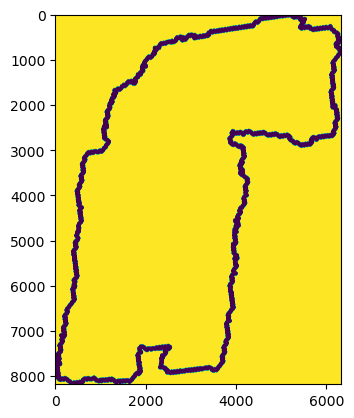

In [6]:
data1 = VesuviusTrainData(
    dir_path="/kaggle/input/vesuvius-challenge-ink-detection/train/1"\
    ,nucleus_shape = nucleus_shape,hull_size=hull_size, z_start=z_start
    , z_end=z_end,give_indx=True,boundarysize = boundarysize)

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (140973980 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


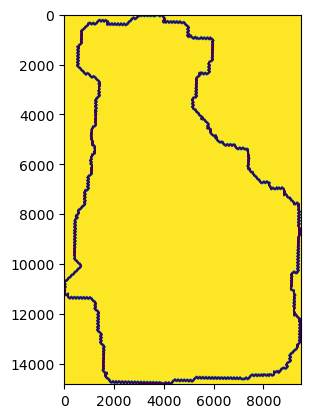

In [7]:
data2 = VesuviusTrainData(
    dir_path="/kaggle/input/vesuvius-challenge-ink-detection/train/2"\
    ,nucleus_shape = nucleus_shape,hull_size=hull_size, z_start=z_start
    , z_end=z_end,give_indx=True,boundarysize = boundarysize,calibrator='calibrate1')

In [8]:
from torch.utils.data import ConcatDataset
merged_dataset = ConcatDataset([data1, data2])

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

#import torch_xla
#import torch_xla.core.xla_model as xm
#device = xm.xla_device()

class RandomNoise(object):
    def __init__(self, mean=0.0, std=1.0):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noise = torch.randn_like(tensor) * self.std + self.mean
        return tensor + torch.abs(noise)
    
def rotate_image(data,target):
    degrees = np.random.choice([90, 180, 270])
    rotated_data = np.rot90(data, k=degrees // 90, axes= (-2, -1)).copy()
    rotated_target = np.rot90(target, k=degrees // 90, axes=(-2, -1)).copy()
    return torch.tensor(rotated_data),torch.tensor(rotated_target)

def random_shift(data,target, max_shift=4):
    x_shift = np.random.randint(-max_shift, max_shift)
    y_shift = np.random.randint(-max_shift, max_shift)
    shifted_data = torch.roll(data, shifts=(x_shift, y_shift), dims=(-2, -1))
    shifted_target = torch.roll(target, shifts=(x_shift, y_shift), dims=(-2, -1))
    
    return shifted_data,shifted_target

class CNN3D(nn.Module):
    def __init__(self):
        super(CNN3D, self).__init__()
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=16, kernel_size=3, padding=1,dtype = torch.float32)
        self.conv2 = nn.Conv3d(in_channels=16, out_channels=32, kernel_size=3, padding=1,dtype = torch.float32)
        self.conv3 = nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, padding=1,dtype = torch.float32)
        self.fc = nn.Linear(1152, 64,dtype = torch.float32)
        
        self.saved_loss = []
        self.saved_epoch = []
        
    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool3d(x, kernel_size=2)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool3d(x, kernel_size=2)
        x = self.conv3(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool3d(x, kernel_size=2)
        x = x.view(x.size(0), -1)  
        x = self.fc(x)
        return x
    
    def augment(self, data, target):
        batch_size = data.size(0)
        rands = torch.rand(batch_size)
        flip1 = transforms.RandomApply([transforms.RandomHorizontalFlip()], p=1)
        flip2 = transforms.RandomApply([transforms.RandomVerticalFlip()], p=1)
        noise = transforms.RandomApply([RandomNoise(mean=0, std=0.005)], p=1)

        for i in range(batch_size):
            if rands[i] < 0.05:
                data[i] = flip1(data[i])
                target[i] = flip1(target[i])
            elif rands[i] < 0.1:
                data[i] = flip2(data[i])
                target[i] = flip2(target[i])
            elif rands[i] < 0.15:
                data[i] = noise(data[i])
            elif rands[i] < 0.25:
                data[i], target[i] = rotate_image(data[i],target[i])
            elif rands[i] < 0.35:
                data[i],target[i] = random_shift(data[i],target[i]) 
                
        return data, target


    def fit(self, train_data,optimizer, criterion, num_epochs,verbose=False): 
        train_loader = DataLoader(train_data, batch_size = 512, shuffle=True)
        for epoch in range(num_epochs):
            loss_list = []
            for batch_idx, (data, target, idxs) in tqdm(enumerate(train_loader)):
                data, target = self.augment(data,target)
                inputs = data.view(data.shape[0],1, *data.shape[1:])
                inputs = inputs.to(device)
                inputs = inputs.type(torch.float32)
                output = (self(inputs))
                target = target.to(device)
                target = target.type(torch.float32)
                optimizer.zero_grad()
                loss = criterion(output, target.view(target.shape[0], -1))
                loss_list.append(loss.item())
                loss.backward()
                optimizer.step()
                if batch_idx % 100 == 0:
                    print(np.mean(loss_list))
            if verbose == True:
                epoch_loss = np.mean(loss_list)
                self.save_loss(epoch_loss,epoch)
                print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")
            
                
    def save_loss(self,epoch_loss,epoch):
        self.saved_loss.append(epoch_loss)
        if len(self.saved_epoch) != 0:
            if self.saved_epoch[-1] > epoch:
                self.saved_epoch.append(self.saved_epoch[-1]+1)
            else:
                 self.saved_epoch.append(epoch)
        else:
            self.saved_epoch.append(epoch)

In [16]:
model = CNN3D()
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))
model.to(device)

CNN3D(
  (conv1): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (fc): Linear(in_features=1152, out_features=64, bias=True)
)

In [17]:
num_epochs = 3
model.fit(merged_dataset,optimizer=optimizer, criterion=criterion, num_epochs=num_epochs,verbose = True)
torch.save(model.state_dict(), 'Combinedweights.pth')

1it [00:01,  1.21s/it]

tensor(0.9778, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


101it [00:37,  2.64it/s]

tensor(0.8932, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


201it [01:14,  2.72it/s]

tensor(0.9315, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


301it [01:50,  2.74it/s]

tensor(0.8966, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


401it [02:27,  2.60it/s]

tensor(0.9100, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


501it [03:03,  2.73it/s]

tensor(0.9829, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


601it [03:40,  2.63it/s]

tensor(0.9173, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


701it [04:20,  2.67it/s]

tensor(0.8894, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


801it [04:57,  2.58it/s]

tensor(0.9311, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


901it [05:34,  2.68it/s]

tensor(0.8868, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


1001it [06:10,  2.76it/s]

tensor(0.8820, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


1101it [06:47,  2.69it/s]

tensor(0.9078, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


1201it [07:23,  2.61it/s]

tensor(0.9169, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


1301it [08:00,  2.72it/s]

tensor(0.8414, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


1401it [08:36,  2.20it/s]

tensor(0.8824, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


1501it [09:12,  2.77it/s]

tensor(0.8379, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


1601it [09:49,  2.78it/s]

tensor(0.8876, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


1701it [10:25,  2.70it/s]

tensor(0.8487, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


1801it [11:01,  2.76it/s]

tensor(0.8920, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


1901it [11:38,  2.75it/s]

tensor(0.8291, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


2001it [12:14,  2.70it/s]

tensor(0.8877, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


2101it [12:50,  2.63it/s]

tensor(0.8354, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


2201it [13:27,  2.61it/s]

tensor(0.9318, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


2301it [14:03,  2.74it/s]

tensor(0.8099, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


2401it [14:40,  2.77it/s]

tensor(0.8231, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


2501it [15:16,  2.55it/s]

tensor(0.8740, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


2601it [15:52,  2.72it/s]

tensor(0.9254, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


2701it [16:29,  2.39it/s]

tensor(0.8686, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


2801it [17:05,  2.73it/s]

tensor(0.9312, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


2901it [17:42,  2.70it/s]

tensor(0.8086, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


3001it [18:18,  2.76it/s]

tensor(0.8157, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


3101it [18:54,  2.73it/s]

tensor(0.9036, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


3201it [19:31,  2.71it/s]

tensor(0.8338, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


3301it [20:07,  2.69it/s]

tensor(0.7392, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


3401it [20:44,  2.71it/s]

tensor(0.8699, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


3501it [21:20,  2.68it/s]

tensor(0.8687, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


3601it [21:57,  2.75it/s]

tensor(0.8512, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


3701it [22:33,  2.77it/s]

tensor(0.8599, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


3755it [22:53,  2.73it/s]


Epoch 1/3, Loss: 0.8719135138705948


1it [00:00,  1.75it/s]

tensor(0.7769, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


101it [00:36,  2.69it/s]

tensor(0.8427, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


201it [01:13,  2.55it/s]

tensor(0.7826, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


301it [01:49,  2.76it/s]

tensor(0.8326, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


401it [02:25,  2.71it/s]

tensor(0.8199, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


501it [03:03,  2.26it/s]

tensor(0.8354, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


556it [03:24,  2.72it/s]


KeyboardInterrupt: 

In [19]:
torch.save(model.state_dict(), 'Combinedweights.pth')

In [ ]:
num_epochs = 3

optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))
model.fit(merged_dataset,optimizer=optimizer, criterion=criterion, num_epochs=num_epochs,verbose = True)
torch.save(model.state_dict(), 'Combinedweights.pth')

In [ ]:
data3 = VesuviusTrainData(
    dir_path="/kaggle/input/vesuvius-challenge-ink-detection/train/3"\
    ,nucleus_shape = nucleus_shape,hull_size=hull_size, z_start=z_start
    , z_end=z_end,give_indx=True,boundarysize = boundarysize,calibrator='calibrate2')

In [ ]:
score = []
preds = []
targs = []
val_loader =DataLoader(data3, batch_size = 512)
for data, target,idxs in tqdm((val_loader)):
    output = model(data.view(data.shape[0],1,*data.shape[1:]).to(device))
    target = target.to(device).view(target.shape[0],64)
    target = target.to(output.dtype)
    score.append(nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))(output, target).item())
    preds.append(torch.round(nn.Sigmoid()(output)).detach().cpu().numpy())
    targs.append(target.detach().cpu().numpy())

print(np.mean(score))

In [ ]:
class Fscore:
    def __init__(self):
        self.epsilon = 1e-7
        self.tp = 0
        self.fp = 0
        self.fn = 0
    
    def accumulate(self, y_true, y_pred):
        # Flatten the input arrays to 1D
        y_true = np.ravel(y_true)
        y_pred = np.ravel(y_pred)
        
        # Update true positives, false positives, and false negatives
        self.tp += np.sum((y_true == 1) & (y_pred == 1))
        self.fp += np.sum((y_true == 0) & (y_pred == 1))
        self.fn += np.sum((y_true == 1) & (y_pred == 0))
    
    def get_score(self, beta=1):
       # Calculate precision, recall, and F-score
        precision = self.tp / (self.tp + self.fp + self.epsilon)
        recall = self.tp / (self.tp + self.fn + self.epsilon)
        f_score = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall + self.epsilon)
    
        return f_score

In [ ]:
score = Fscore()
for p,t in zip(preds,targs):
     score.accumulate(t,p)
        
print(score.get_score(beta=0.5))

In [ ]:
class PictureBuilder:
    def __init__(self,snippet_width=16,snippet_height=16):
        self.full_width = 6452
        self.full_height = 8298
    
        self.snippet_width = snippet_width
        self.snippet_height = snippet_height

        self.full_picture = np.zeros((self.full_height, self.full_width))
        

    def __call__(self,indx_matrix,snippet_matrix):
        height = indx_matrix[0]
        width = indx_matrix[1]
        temp = insert_snippet(self.full_picture,height,width,self.snippet_height\
                       ,self.snippet_width,snippet_matrix)
        self.full_picture = temp
        
    
    def _get(self):
        return self.full_picture

@numba.njit()
def insert_snippet(full_picture,height,width,sheight,swidth,smatrix):
    for i in range(sheight):
        for j in range(swidth):
            full_picture[height[i],width[j]] = smatrix[i,j]
    return full_picture

In [ ]:
picture = PictureBuilder(snippet_width=8,snippet_height=8)
pics_loader = DataLoader(data3, batch_size=1)
for batch_idx, (x_data, target, indx_arr) in tqdm(enumerate(pics_loader)):
    x_data = x_data.view(1,*x_data.shape)
    x_data = torch.tensor((x_data).to(device))
    pred =  torch.sigmoid(model(x_data))
    pred_cpu = pred.detach().cpu().numpy()
    picture(indx_arr[0, :].T.numpy(), pred_cpu.reshape(8, 8))
    if batch_idx > 400000:
        break

plt.imshow(np.round(picture._get()))

In [ ]:
plt.imshow(np.round(picture._get()))